# About Logic Tensor Network (LTN)
This notebook decomposes and investigates an LTN library in order to understand its building blocks.<br>
This is work in progress.

This video explains the tutorials https://www.youtube.com/watch?v=KhkCjCmK8m0 (in second half)<br>
`Rights to be wrong reserved`

In [5]:
import sys
# path to LTN to include in system paths
path = 'C:\\Users\\Greg\\Documents\\Projects\\LTN'
sys.path.append(path)

import os
import tensorflow as tf
import logictensornetworks as ltn
import numpy as np
import utils_ltn
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline
print('LTN imported from: ', os.path.dirname(ltn.__file__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LTN imported from:  C:\Users\Greg\Documents\Projects\LTN


In [7]:
LAYERS = 4
BIAS_factor = 0.0
BIAS = 0.0

# Global placeholders for logical symbols
F_And = None
F_Or = None
F_Implies = None
F_Equiv = None
F_Not = None
F_Forall = None
F_Exists = None

## Setting Norms
This is a hyper-parametr that defines how logical operators are calculated, with the following options:
- min
- Lukasiewicz
- product
- mean

wff, wffs = "well formated formula/s". Formulas are build using groundings in Real vectors.<br> 
(examples to add).
The norms are used in Fuzzy Sets Theory.<br>
Some videos and readings on this matters:
- https://www.youtube.com/watch?v=oWqXwCEfY78
- https://www.youtube.com/watch?v=a2i-lHS-c_I
- ...


In [7]:
# from the ltn library
def set_tnorm(tnorm):
    assert tnorm in ['min','luk','prod','mean','']
    global F_And,F_Or,F_Implies,F_Not,F_Equiv,F_Forall
    if tnorm == "min":
        def F_And(wffs):
            return tf.reduce_min(wffs,axis=-1,keepdims=True)

        def F_Or(wffs):
            return tf.reduce_max(wffs,axis=-1,keepdims=True)

        def F_Implies(wff1, wff2):
            return tf.maximum(tf.to_float(tf.less_equal(wff1,wff2)),wff2)

        def F_Not(wff):
            return 1 - wff

        def F_Equiv(wff1,wff2):
            return tf.maximum(tf.to_float(tf.equal(wff1,wff2)),tf.minimum(wff1,wff2))

    if tnorm == "prod":
        def F_And(wffs):
            return tf.reduce_prod(wffs,axis=-1,keepdims=True)

        def F_Or(wffs):
            return 1-tf.reduce_prod(1-wffs,axis=-1,keepdims=True)

        def F_Implies(wff1, wff2):
            le_wff1_wff2 = tf.to_float(tf.less_equal(wff1,wff2))
            gt_wff1_wff2 = tf.to_float(tf.greater(wff1,wff2))
            return tf.cond(tf.equal(wff1[0],0),lambda:le_wff1_wff2 + gt_wff1_wff2*wff2/wff1,lambda:tf.constant([1.0]))

        def F_Not(wff):
            # according to standard goedel logic is
            # return tf.to_float(tf.equal(wff,1))
            return 1-wff

        def F_Equiv(wff1,wff2):
            return tf.minimum(wff1/wff2,wff2/wff1)

    if tnorm == "mean":
        def F_And(wffs):
            return tf.reduce_mean(wffs,axis=-1,keepdims=True)

        def F_Or(wffs):
            return tf.reduce_max(wffs,axis=-1,keepdims=True)

        def F_Implies(wff1, wff2):
            return tf.clip_by_value(2*wff2-wff1,0,1)

        def F_Not(wff):
            return 1 - wff

        def F_Equiv(wff1,wff2):
            return 1 - tf.abs(wff1-wff2)

    if tnorm == "luk":
        def F_And(wffs):
            return tf.maximum(0.0,tf.reduce_sum(wffs,axis=-1,keepdims=True)+1-tf.to_float(tf.shape(wffs)[-1]))

        def F_Or(wffs):
            return tf.minimum(tf.reduce_sum(wffs,axis=-1,keepdims=True),1.0,)

        def F_Implies(wff1, wff2):
            return tf.minimum(1.,1 - wff1 + wff2)

        def F_Not(wff):
            return 1 - wff

        def F_Equiv(wff1,wff2):
            return 1 - tf.abs(wff1-wff2)
        


The function `draw_ltn_operators` in `utils_ltn.py` has been created to visualise either unary or binary operators.<br>

[[0.5 0.1]
 [0.2 0.3]
 [0.6 0.2]
 [0.2 0.4]
 [0.3 0.6]]


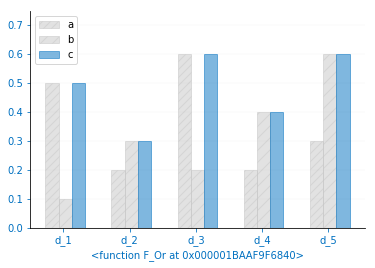

In [14]:
# Set a desired norm
ltn.set_tnorm("min")

# some data 
data = np.array([[0.5, 0.2, 0.6, 0.2, 0.3], 
                 [0.1, 0.3, 0.2, 0.4, 0.6]], dtype=np.float32)

labels = ['d_'+str(i+1) for i in np.arange(len(data[0]))]

formulas = tf.placeholder(dtype=tf.float32)


data_a, data_b = data[0], data[1] 

a = ltn.variable('a', data_a)
b = ltn.variable('a', data_b)

op = ltn.F_Or
if op == ltn.F_And or op == ltn.F_Or:
    with tf.Session() as sess:
        data_in = np.stack(data, axis=1)
        c = sess.run(op(formulas), feed_dict={formulas: data_in}) 
        data_c = np.array(utils_ltn.flat_list(c))
        print(data_in)
        utils_ltn.draw_ltn_operators(a=data_a, b=data_b, c=data_c, title=op, labels=labels)

elif op == ltn.F_Implies or op == ltn.F_Equiv:
    with tf.Session() as sess:
        c = sess.run(op(a, b), feed_dict={a:data_a, b:data_b})
        data_c = np.array(c)
        utils_ltn.draw_ltn_operators(a=data_a, b=data_b, c=data_c, title=op, labels=labels)
    
elif op == ltn.F_Not:
    with tf.Session() as sess:
        c = sess.run(op(a), feed_dict={a:data_a})
        data_c = np.array(c)
        utils_ltn.draw_ltn_operators(a=data_a, c=data_c, title=op, labels=labels)
else: 'Not implemented'

In [25]:
def set_universal_aggreg(aggreg):
    assert aggreg in ['hmean','min','mean']
    global F_Forall
    if aggreg == "hmean":
        def F_Forall(axis,wff):
            return 1/tf.reduce_mean(1/(wff+1e-10),axis=axis)

    if aggreg == "min":
        def F_Forall(axis,wff):
            return tf.reduce_min(wff,axis=axis)

    if aggreg == "mean":
        def F_Forall(axis,wff):
            return tf.reduce_mean(wff, axis=axis)


def set_existential_aggregator(aggreg):
    assert  aggreg in ['max']
    global F_Exists
    if aggreg == "max":
        def F_Exists(axis, wff):
            return tf.reduce_max(wff, axis=axis)
        
set_universal_aggreg("hmean")
set_existential_aggregator("max")

In [68]:
ltn.Or()

<function logictensornetworks.Or>

............

# To be continued piece by piece

In [69]:
def Or(*wffs):
    if len(wffs) == 0:
        result = tf.constant(0.0)
        result.doms = []
    else:
        cross_wffs,_ = cross_args(wffs)
        label = "_OR_".join([wff.name.split(":")[0] for wff in wffs])
        result = tf.identity(F_Or(cross_wffs),name=label)
        result.doms = cross_wffs.doms
    return result


def And(*wffs):
    if len(wffs) == 0:
        result = tf.constant(1.0)
        result.doms = []
    else:
        cross_wffs,_ = cross_args(wffs)
        label = "_AND_".join([wff.name.split(":")[0] for wff in wffs])
        result = tf.identity(F_And(cross_wffs),name=label)
        result.doms = cross_wffs.doms
    return result


#def Or(*wffs):
#    if len(wffs) == 0:
 #       result = tf.constant(0.0)
#        result.doms = []
#    else:
#        cross_wffs,_ = cross_args(wffs)
 #       label = "_OR_".join([wff.name.split(":")[0] for wff in wffs])
  #      result = tf.identity(F_Or(cross_wffs),name=label)
 #       result.doms = cross_wffs.doms
#    return result


def Implies(wff1, wff2):
    _, cross_wffs = cross_2args(wff1,wff2)
    label = wff1.name.split(":")[0] + "_IMP_" + wff2.name.split(":")[0]
    result = F_Implies(cross_wffs[0],cross_wffs[1])
    result = tf.identity(result,name=label)
    result.doms = cross_wffs[0].doms
    return result

def Not(wff):
    result = F_Not(wff)
    label = "NOT_" + wff.name.split(":")[0]
    result = tf.identity(result,name=label)
    result.doms = wff.doms
    return result

def Equiv(wff1,wff2):
    _, cross_wffs = cross_2args(wff1,wff2)
    label = wff1.name.split(":")[0] + "_IFF_" + wff2.name.split(":")[0]
    result = F_Equiv(cross_wffs[0],cross_wffs[1])
    result.doms = cross_wffs[0].doms
    return result

def Forall(vars,wff):
    if type(vars) is not tuple:
        vars = (vars,)
    result_doms = [x for x in wff.doms if x not in [var.doms[0] for var in vars]]
    quantif_axis = [wff.doms.index(var.doms[0]) for var in vars]
    not_empty_vars = tf.cast(tf.reduce_prod(tf.stack([tf.size(var) for var in vars])),tf.bool)
    ones = tf.ones((1,)*(len(result_doms)+1))
    result = tf.cond(not_empty_vars,lambda:F_Forall(quantif_axis,wff),lambda:ones)
    result.doms = result_doms
    return result

def Exists(vars,wff):
    if type(vars) is not tuple:
        vars = (vars,)
    result_doms = [x for x in wff.doms if x not in [var.doms[0] for var in vars]]
    quantif_axis = [wff.doms.index(var.doms[0]) for var in vars]
    not_empty_vars = tf.cast(tf.reduce_prod(tf.stack([tf.size(var) for var in vars])),tf.bool)
    zeros = tf.zeros((1,)*(len(result_doms)+1))
    result = tf.cond(not_empty_vars,lambda:F_Exists(quantif_axis,wff),lambda:zeros)
    result.doms = result_doms
    return result

# tf.cast
# tf.stack VS np.stack
# tf.size


def variable(label,number_of_features_or_feed):
    if type(number_of_features_or_feed) is int:
        result = tf.placeholder(dtype=tf.float32,shape=(None,number_of_features_or_feed),name=label)
    elif isinstance(number_of_features_or_feed,tf.Tensor):
        result = tf.identity(number_of_features_or_feed,name=label)
    else:
        result = tf.constant(number_of_features_or_feed,name=label)
    result.doms = [label]
    return result




def constant(label,value=None,
                 min_value=None,
                 max_value=None):
    label = "ltn_constant_"+label
    if value is not None:
        result = tf.constant(value,name=label)
    else:
        result = tf.Variable(tf.random_uniform(
                shape=(1,len(min_value)),
                minval=min_value,
                maxval=max_value,name=label))
    result.doms = []
    return result

def function(label, input_shape_spec, output_shape_spec=1,fun_definition=None):
    if type(input_shape_spec) is list:
        number_of_features = sum([int(v.shape[1]) for v in input_shape_spec])
    elif type(input_shape_spec) is tf.Tensor:
        number_of_features = int(input_shape_spec.shape[1])
    else:
        number_of_features = input_shape_spec
    if fun_definition is None:
        W = tf.Variable(
                tf.random_normal(
                    [number_of_features + 1,output_shape_spec],mean=0,stddev=1), name="W" + label)
        def apply_fun(*args):
            tensor_args = tf.concat(args,axis=1)
            X = tf.concat([tf.ones((tf.shape(tensor_args)[0], 1)),
                           tensor_args], 1)
            result = tf.matmul(X,W)
            return result
        pars = [W]
    else:
        def apply_fun(*args):
            return fun_definition(*args)
        pars = []

    def fun(*args):
        crossed_args, list_of_args_in_crossed_args = cross_args(args)
        result = apply_fun(*list_of_args_in_crossed_args)
        if crossed_args.doms != []:
            result = tf.reshape(result, tf.concat([tf.shape(crossed_args)[:-1],
                                                   tf.shape(result)[-1:]],axis=0))
        else:
            result = tf.reshape(result, (output_shape_spec,))
        result.doms = crossed_args.doms
        return result
    fun.pars = pars
    fun.label=label
    return fun

def proposition(label,initial_value=None,value=None):
    if value is not None:
        assert 0 <= value and value <= 1
        result = tf.constant([value])
    elif initial_value is not None:
        assert 0 <= initial_value <= 1
        result = tf.Variable(initial_value=[value])
    else:
        result = tf.expand_dims(tf.clip_by_value(tf.Variable(tf.random_normal(shape=(),mean=.5,stddev=.5)),0.,1.),dim=0)
    result.doms = ()
    return result

def predicate(label,number_of_features_or_vars,pred_definition=None):
    global BIAS
    if type(number_of_features_or_vars) is list:
        number_of_features = sum([int(v.shape[1]) for v in number_of_features_or_vars])
    elif type(number_of_features_or_vars) is tf.Tensor:
        number_of_features = int(number_of_features_or_vars.shape[1])
    else:
        number_of_features = number_of_features_or_vars
    if pred_definition is None:
        W = tf.matrix_band_part(
            tf.Variable(
                tf.random_normal(
                    [LAYERS,
                     number_of_features + 1,
                     number_of_features + 1],mean=0,stddev=1), name="W" + label), 0, -1)
        u = tf.Variable(tf.ones([LAYERS, 1]),
                        name="u" + label)
        def apply_pred(*args):
            app_label = label + "/" + "_".join([arg.name.split(":")[0] for arg in args]) + "/"
            tensor_args = tf.concat(args,axis=1)
            X = tf.concat([tf.ones((tf.shape(tensor_args)[0], 1)),
                           tensor_args], 1)
            XW = tf.matmul(tf.tile(tf.expand_dims(X, 0), [LAYERS, 1, 1]), W)
            XWX = tf.squeeze(tf.matmul(tf.expand_dims(X, 1), tf.transpose(XW, [1, 2, 0])), axis=[1])
            gX = tf.matmul(tf.tanh(XWX), u)
            result = tf.sigmoid(gX, name=app_label)
            return result
        pars = [W,u]
    else:
        def apply_pred(*args):
            return pred_definition(*args)
        pars = []

    def pred(*args):
        global BIAS
        crossed_args, list_of_args_in_crossed_args = cross_args(args)
        result = apply_pred(*list_of_args_in_crossed_args)
        if crossed_args.doms != []:
            result = tf.reshape(result, tf.concat([tf.shape(crossed_args)[:-1],[1]],axis=0))
        else:
            result = tf.reshape(result, (1,))
        result.doms = crossed_args.doms
        BIAS = tf.divide(BIAS + .5 - tf.reduce_mean(result),2)*BIAS_factor
        return result
    pred.pars = pars
    pred.label=label
    return pred

def cross_args(args):
    result = args[0]
    for arg in args[1:]:
        result,_ = cross_2args(result,arg)
    result_flat = tf.reshape(result,
                             (tf.reduce_prod(tf.shape(result)[:-1]),
                              tf.shape(result)[-1]))
    result_args = tf.split(result_flat,[tf.shape(arg)[-1] for arg in args],1)
    return result, result_args

def cross_2args(X,Y):
    if X.doms == [] and Y.doms == []:
        result = tf.concat([X,Y],axis=-1)
        result.doms = []
        return result,[X,Y]
    X_Y = set(X.doms) - set(Y.doms)
    Y_X = set(Y.doms) - set(X.doms)
    eX = X
    eX_doms = [x for x in X.doms]
    for y in Y_X:
        eX = tf.expand_dims(eX,0)
        eX_doms.append(y)
    eY = Y
    eY_doms = [y for y in Y.doms]
    for x in X_Y:
        eY = tf.expand_dims(eY,0)
        eY_doms.append(x)
    perm_eY = []
    for y in eY_doms:
        perm_eY.append(eX_doms.index(y))
    eY = tf.transpose(eY,perm_eY + [len(perm_eY)])
    mult_eX = [1]*(len(eX_doms)+1)
    mult_eY = [1]*(len(eY_doms)+1)
    for i in range(len(mult_eX)-1):
        mult_eX[i] = tf.maximum(1,tf.floor_div(tf.shape(eY)[i],tf.shape(eX)[i]))
        mult_eY[i] = tf.maximum(1,tf.floor_div(tf.shape(eX)[i],tf.shape(eY)[i]))
    result1 = tf.tile(eX,mult_eX)
    result2 = tf.tile(eY,mult_eY)
    result = tf.concat([result1,result2],axis=-1)
    result1.doms = eX_doms
    result2.doms = eX_doms
    result.doms = eX_doms
    return result,[result1,result2]

In [15]:
def cross_2args(X,Y):
    if X.doms == [] and Y.doms == []:
        result = tf.concat([X,Y],axis=-1)
        result.doms = []
        return result,[X,Y]
    X_Y = set(X.doms) - set(Y.doms)
    Y_X = set(Y.doms) - set(X.doms)
    eX = X
    eX_doms = [x for x in X.doms]
    for y in Y_X:
        eX = tf.expand_dims(eX,0)
        eX_doms.append(y)
    eY = Y
    eY_doms = [y for y in Y.doms]
    for x in X_Y:
        eY = tf.expand_dims(eY,0)
        eY_doms.append(x)
    perm_eY = []
    for y in eY_doms:
        perm_eY.append(eX_doms.index(y))
    eY = tf.transpose(eY,perm_eY + [len(perm_eY)])
    mult_eX = [1]*(len(eX_doms)+1)
    mult_eY = [1]*(len(eY_doms)+1)
    for i in range(len(mult_eX)-1):
        mult_eX[i] = tf.maximum(1,tf.floor_div(tf.shape(eY)[i],tf.shape(eX)[i]))
        mult_eY[i] = tf.maximum(1,tf.floor_div(tf.shape(eX)[i],tf.shape(eY)[i]))
    result1 = tf.tile(eX,mult_eX)
    result2 = tf.tile(eY,mult_eY)
    result = tf.concat([result1,result2],axis=-1)
    result1.doms = eX_doms
    result2.doms = eX_doms
    result.doms = eX_doms
    return result,[result1,result2]

In [ ]:
result, [result1,result2] = cross_2args

In [34]:
ltn.And(a)

<tf.Tensor 'a_6_2:0' shape=<unknown> dtype=float32>

In [33]:
c = tf.placeholder(tf.float32)
sess = tf.Session()
data_in = np.stack(data, axis=1)
l = sess.run(Or(c), feed_dict={c:c_data})

NameError: name 'Or' is not defined

In [31]:
with tf.Session() as sess:
    c = sess.run(And(a)); 
    data_c = np.array(c)
    utils.ltn_draw_logicals(a=data_a, b=data_b, c=data_c, title=op, labels=labels)

NameError: name 'And' is not defined